In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm
import plotly.graph_objects as go


def make_batch_level_matrix_pandas(pls_scores_df,
                                   batch_col='batch_id',
                                   time_col='batch_time_h',
                                   comp_prefix='comp_'):
    """
    Convert long-format scores (batch, time, comp_k) into a batch-level matrix
    with columns like comp_1_0.0, comp_1_1.0, ...
    """
    comp_cols = [c for c in pls_scores_df.columns if c.startswith(comp_prefix)]

    long = pls_scores_df.melt(
        id_vars=[batch_col, time_col],
        value_vars=comp_cols,
        var_name='component',
        value_name='score'
    )

    wide = (
        long
        .pivot(index=batch_col, columns=['component', time_col], values='score')
        .sort_index(axis=1, level=[0, 1])
    )

    wide.columns = [f"{comp}_{t}" for (comp, t) in wide.columns]

    return wide


## Part 1 1 (Observational) - Generate PLS Model from Data

First we train a model off a set of 'good' batches.

#load completed batches (good batches)
#generate df_model dataframe, select  predicts 
#set up PLS model that predicts y (time) on X (input parameters, like metabolites or process signals)
#perform cross validation using n components, manually select model n_components
#generate scores (T) through PLS_1. Save to T_df dataframe
#Rearrange to X_T (wide)
#Calculate means and intervals.
#Plot

In [ ]:
class BatchEvolutionModel:
    def __init__(
        self,
        X_cols,
        batch_col='batch_id',
        time_col='batch_time_h',
        y_time_col='batch_time_h'
    ):
        """
        A reusable BEM pipeline.
        """
        if X_cols is None or len(X_cols) == 0:
            raise ValueError("X_cols must be a non-empty list of column names.")

        self.X_cols = X_cols
        self.batch_col = batch_col
        self.time_col = time_col
        self.y_time_col = y_time_col #time

        # Stage 1 (scores) state
        self.scaler_X = None #(NxJ)xK
        self.pls_scores = None  
        self.n_components = None #A
        self.score_cols = None 
        
        self.summary_df = None
        self.pls_scores_df_train = None #(NxJ)xA. dataframe. gets dmodx and T2 added on later.
        self.X_T_train = None  #Nx(JxA). converted matrix.
        self._df_model_scores = None #(NxJ)xK. dataframe
        self._X_scaled_scores = None #(NxJ)xA. np matrix.
        self._y_scores = None
        self.cv_scores_ = None  # to store CV MSE curve

        self.T2_train = None
        self.DModX_train = None
        self.T2_limit = None
        self.DModX_limit = None
        self.T2_limit_3sd = None
        self.DModX_limit_3sd = None
        # Stage 2 (response / titer) state
        self.scaler_X2 = None
        self.pls_y = None
        self.y_cols = None #titer
        self.meta_cols_for_y = None  # e.g. ['batch_id', 'solution_type']

    def fit_scores(
        self,
        df,
        n_splits=5,
        max_components=None,
        plot_cv=True,
        auto_select=True,
    ):
        """
        Prepare and fit the score model. Input is data in clean format (NxJ)xK columns. Find scores. Save scaled X, scores, and cv results.
        """
        df_train = df.copy()

        # 2) build df_model and y (time)
        df_model = df_train[[self.time_col, self.batch_col] + self.X_cols].copy()
        df_model = df_model.sort_values([self.batch_col, self.time_col])

        X = df_model[self.X_cols].to_numpy()
        y = df_model[[self.y_time_col]].to_numpy()  # time as y

        # 3) scale X
        self.scaler_X = StandardScaler()
        X_scaled = self.scaler_X.fit_transform(X)

        # store for later refits
        self._df_model_scores = df_model
        self._X_scaled_scores = X_scaled
        self._y_scores = y

        # 4) choose # components via CV
        if max_components is None:
            max_components = len(self.X_cols)

        kfold = skm.KFold(n_splits, random_state=0, shuffle=True)
        pls = PLSRegression()
        param_grid = {'n_components': range(1, max_components + 1)}

        grid = skm.GridSearchCV(
            pls,
            param_grid,
            cv=kfold,
            scoring='neg_mean_squared_error'
        )
        grid.fit(X_scaled, y)

        mean_mse = -grid.cv_results_['mean_test_score']
        std_mse = grid.cv_results_['std_test_score'] / np.sqrt(n_splits)
        n_list = list(param_grid['n_components'])

        best_n = grid.best_params_['n_components']
        print(f"[BEM] CV complete. Best # of score components (by MSE): {best_n}")

        # store CV results
        self.cv_scores_ = {
            "n_components": np.array(n_list),
            "mean_mse": np.array(mean_mse),
            "std_mse": np.array(std_mse),
        }

        # 5) plot CV curve
        if plot_cv:
            plt.figure(figsize=(6, 6))
            plt.errorbar(n_list, mean_mse, yerr=std_mse, fmt='o-', capsize=5)
            plt.xlabel("# of PLS components")
            plt.ylabel("Cross-validated MSE")
            plt.title("CV MSE vs # of components (scores)")
            plt.xticks(np.arange(min(n_list), max(n_list) + 1, 1))
            plt.show()

        # 6) either auto-select or wait for user choice
        if auto_select:
            print(f"[BEM] Auto-selecting n_components = {best_n}")
            self._finalize_scores_model(n_components=best_n)
        else:
            print("[BEM] Not fitting final score model yet. "
                  "Call choose_n_components(k) after inspecting the CV plot.")

        return self

    def choose_n_components(self, n_components):
        """
        After running fit_scores(..., auto_select=False),
        call this to choose how many components to use.

        Example:
            bem.fit_scores(df, auto_select=False)
            # inspect CV plot
            bem.choose_n_components(2)
        """
        print(f"[BEM] Fitting score model with n_components = {n_components}")
        self.finalize_scores_model(n_components=n_components)
        return self

    def finalize_scores_model(self, n_components):
        """
        Internal: given stored X_scaled & y, fit PLS with n_components,
        compute scores (T), X_T_train, and bounds. creates df_summary with means, stdevs, and +/-3SD
        """
        if self._X_scaled_scores is None or self._y_scores is None or self._df_model_scores is None:
            raise RuntimeError("No training data stored. Run fit_scores() first.")

        self.n_components = int(n_components)

        # fit PLS with chosen number of components
        self.pls_scores = PLSRegression(n_components=self.n_components)
        self.pls_scores.fit(self._X_scaled_scores, self._y_scores)
        X_scaled=self._X_scaled_scores
        T = self.pls_scores.transform(X_scaled)
        P = self.pls_scores.x_loadings_

        N, p = X_scaled.shape
        A = self.n_components

        # Hotelling T²
        cov_T = np.cov(T, rowvar=False)
        cov_T_inv = np.linalg.inv(cov_T)
        self._cov_T_inv = cov_T_inv  # store for later

        T2_train = np.einsum('ij,jk,ik->i', T, cov_T_inv, T)
        self.T2_train = T2_train

        # DModX
        X_hat = T @ P.T
        E = X_scaled - X_hat
        SPE_train = np.sum(E**2, axis=1)
        DModX_train = np.sqrt(SPE_train / (p - A))
        self.DModX_train = DModX_train

        # limits (you can pick style)
        # self.T2_limit = np.quantile(T2_train, 0.99)
        # self.DModX_limit = np.quantile(DModX_train, 0.99)

        # or "mean + 3*std" style
        self.T2_limit_3sd = T2_train.mean() + 3 * T2_train.std()
        self.DModX_limit_3sd = DModX_train.mean() + 3 * DModX_train.std()


        self.score_cols = [f"comp_{i+1}" for i in range(self.n_components)]
        T_df = pd.DataFrame(T, columns=self.score_cols, index=self._df_model_scores.index)

        # long scores df (time, batch, comp_k)
        self.pls_scores_df_train = pd.concat(
            [self._df_model_scores[[self.time_col, self.batch_col]].reset_index(drop=True),
             T_df.reset_index(drop=True)],
            axis=1
        )

        # --- NEW: attach per-sample diagnostics to training scores df ---
        self.pls_scores_df_train["T2"] = T2_train
        self.pls_scores_df_train["DModX"] = DModX_train
        
        # batch-level matrix
        self.X_T_train = make_batch_level_matrix_pandas(
            self.pls_scores_df_train,
            batch_col=self.batch_col,
            time_col=self.time_col,
            comp_prefix='comp_'
        )

        # mean/std/±3SD
        mean_row = self.X_T_train.mean(axis=0)
        std_row = self.X_T_train.std(axis=0)
        upper = mean_row + 3 * std_row
        lower = mean_row - 3 * std_row

        self.summary_df = pd.DataFrame(
            [mean_row, std_row, upper, lower],
            index=['mean', 'std', 'upper_3sd', 'lower_3sd']
        )

    def transform_new(self, df_new):
        """
        Use the trained score model to compute:
        - pls_scores_df_new (long format). Uses same X_scaler transform, as well as PLS transform as training set.
        - X_T_new (batch-level matrix, aligned to training columns)
        """
        if self.scaler_X is None or self.pls_scores is None:
            raise RuntimeError("Call fit_scores() before transform_new().")

        df_model_new = df_new[[self.time_col, self.batch_col] + self.X_cols].copy()
        df_model_new = df_model_new.sort_values([self.batch_col, self.time_col])

        X_new = df_model_new[self.X_cols].to_numpy()
        X_new_scaled = self.scaler_X.transform(X_new)

        T_new = self.pls_scores.transform(X_new_scaled)
        P = self.pls_scores.x_loadings_
        A = self.n_components
        p = X_new_scaled.shape[1]
        T2_new = np.einsum('ij,jk,ik->i', T_new, self._cov_T_inv, T_new)
        X_hat_new = T_new @ P.T
        E_new = X_new_scaled - X_hat_new
        SPE_new = np.sum(E_new**2, axis=1)
        DModX_new = np.sqrt(SPE_new / (p - A))


        T_new_df = pd.DataFrame(T_new, columns=self.score_cols, index=df_model_new.index)

        pls_scores_df_new = pd.concat(
            [df_model_new[[self.time_col, self.batch_col]].reset_index(drop=True),
            T_new_df.reset_index(drop=True)],
            axis=1
        )
        
        pls_scores_df_new["T2"] = T2_new
        pls_scores_df_new["DModX"] = DModX_new
        
        X_T_new = make_batch_level_matrix_pandas(
            pls_scores_df_new,
            batch_col=self.batch_col,
            time_col=self.time_col,
            comp_prefix='comp_'
        )

        # align to training columns
        X_T_new_aligned = X_T_new.reindex(columns=self.X_T_train.columns, fill_value=np.nan)

        return pls_scores_df_new, X_T_new_aligned
    
    def plot_scores(
        self,
        components=None,
        X_T_new=None,
        new_name_prefix='NEW ',
        show=True
    ):
        """
        Plot one figure per component:
          - training batches as many thin, light lines
          - ±3·SD bounds
          - optional new batches as bold dark lines
        """
        if self.X_T_train is None or self.summary_df is None:
            raise RuntimeError("Call fit_scores() before plot_scores().")

        if components is None:
            components = self.n_components

        figs = []

        for i in range(1, components + 1):
            comp_name = f'comp_{i}'
            comp_cols = [c for c in self.X_T_train.columns if c.startswith(comp_name)]
            if not comp_cols:
                raise ValueError(f"No columns found for component {i}")

            # extract times from col names like 'comp_1_0.0'
            def extract_time(col):
                time_str = col.split(comp_name)[-1].lstrip('_')
                return float(time_str)

            times_and_cols = [(extract_time(c), c) for c in comp_cols]
            times_and_cols.sort(key=lambda x: x[0])
            times = [t for t, _ in times_and_cols]
            sorted_cols = [c for _, c in times_and_cols]

            comp_matrix_train = self.X_T_train[sorted_cols]

            mean_vals = self.summary_df.loc['mean', sorted_cols]
            upper_vals = self.summary_df.loc['upper_3sd', sorted_cols]
            lower_vals = self.summary_df.loc['lower_3sd', sorted_cols]

            fig = go.Figure()

            # training batches: light gray, thin
            for batch_id, row in comp_matrix_train.iterrows():
                fig.add_trace(
                    go.Scatter(
                        x=times,
                        y=row.values,
                        mode='lines',
                        name=str(batch_id),
                        line=dict(width=1),
                        hovertemplate='time: %{x}<br>score: %{y}<extra>' +
                                      str(batch_id) + '</extra>',
                        showlegend=False,  # keep legend from being huge
                    )
                )

            # new batches: bold, dark, thicker line & markers
            if X_T_new is not None:
                X_T_new_comp = X_T_new.reindex(columns=sorted_cols)
                for batch_id, row in X_T_new_comp.iterrows():
                    fig.add_trace(
                        go.Scatter(
                            x=times,
                            y=row.values,
                            mode='lines+markers',
                            name=f"{new_name_prefix}{batch_id}",
                            line=dict(width=3, color='darkblue'),
                            marker=dict(size=7, symbol='circle'),
                            hovertemplate='time: %{x}<br>score: %{y}<extra>' +
                                          f"{new_name_prefix}{batch_id}" + '</extra>',
                        )
                    )

            # bounds
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=upper_vals.values,
                    mode='lines',
                    name='upper (mean + 3·SD)',
                    line=dict(dash='dot'),
                    hovertemplate='time: %{x}<br>upper: %{y}<extra></extra>',
                )
            )
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=lower_vals.values,
                    mode='lines',
                    name='lower (mean - 3·SD)',
                    line=dict(dash='dot'),
                    hovertemplate='time: %{x}<br>lower: %{y}<extra></extra>',
                )
            )

            fig.update_layout(
                title=f"Component {i} scores over time with ±3·SD bounds",
                xaxis_title="Time (h)",
                yaxis_title=f"Component {i} score",
                legend_title="Batch / Bounds",
                plot_bgcolor="white",
                paper_bgcolor="white",
                width=700,
                height=450,
            )
            # light blue grid on a white background
            fig.update_xaxes(
                showgrid=True,
                gridcolor="lightblue",   # or "#ADD8E6"
                zeroline=False,
            )
            fig.update_yaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )

            if show:
                print(f"[BEM] plotting component {i}")
                fig.show()

            figs.append(fig)

        return figs
    
    def plot_T2_trace(
        self,
        df_scores,
        batch_id,
        use_3sd_limit=True,
        title_prefix="Hotelling T²",
        show=True,
):
        """
        Plot Hotelling's T² vs time for a given batch, with a horizontal control limit.
        """


        # pick the limit
        if use_3sd_limit:
            limit = self.T2_limit_3sd
            limit_label = "T² limit (mean + 3·SD)"
        else:
            # fall back to quantile-based if you have it, otherwise use 3SD
            limit = getattr(self, "T2_limit", None) or self.T2_limit_3sd
            limit_label = "T² limit"

        # filter this batch
        mask = (df_scores[self.batch_col].astype(str) == str(batch_id))
        df_b = df_scores.loc[mask].copy()

        if df_b.empty:
            raise ValueError(f"No rows found for batch_id={batch_id!r} in df_scores.")

        df_b = df_b.sort_values(self.time_col)

        x = df_b[self.time_col].values
        y_T2 = df_b["T2"].values

        fig = go.Figure()

        # T² line for this batch
        fig.add_trace(
            go.Scatter(
                x=x,
                y=y_T2,
                mode="lines+markers",
                name=f"Batch {batch_id} T²",
                line=dict(width=3),
                marker=dict(size=8),
                hovertemplate=(
                    f"{self.time_col}: "+"%{x}<br>"
                    "T²: %{y}<extra>"+f"{batch_id}"+"</extra>"
                ),
            )
        )

        # Horizontal limit line
        fig.add_trace(
            go.Scatter(
                x=[x.min(), x.max()],
                y=[limit, limit],
                mode="lines",
                name=limit_label,
                line=dict(dash="dash"),
                hoverinfo="skip",
            )
        )

        fig.update_layout(
            title=f"{title_prefix} – batch {batch_id}",
            xaxis_title=self.time_col,
            yaxis_title="T²",
            legend_title="Trace",
        )

        if show:
            fig.show()
        return fig
    
    def plot_DModX_trace(
            self,
            df_scores,
            batch_id,
            use_3sd_limit=True,
            title_prefix="DModX (Distance to Model)",
            show=True,
    ):
        """
        Plot DModX vs time for a given batch, with a horizontal control limit.
        """

        if use_3sd_limit:
            limit = self.DModX_limit_3sd
            limit_label = "DModX limit (mean + 3·SD)"
        else:
            limit = getattr(self, "DModX_limit", None) or self.DModX_limit_3sd
            limit_label = "DModX limit"

        mask = (df_scores[self.batch_col].astype(str) == str(batch_id))
        df_b = df_scores.loc[mask].copy()

        if df_b.empty:
            raise ValueError(f"No rows found for batch_id={batch_id!r} in df_scores.")

        df_b = df_b.sort_values(self.time_col)

        x = df_b[self.time_col].values
        y_D = df_b["DModX"].values

        fig = go.Figure()

        fig.add_trace(
            go.Scatter(
                x=x,
                y=y_D,
                mode="lines+markers",
                name=f"Batch {batch_id} DModX",
                line=dict(width=3),
                marker=dict(size=8),
                hovertemplate=(
                    f"{self.time_col}: "+"%{x}<br>"
                    "DModX: %{y}<extra>"+f"{batch_id}"+"</extra>"
                ),
            )
        )

        fig.add_trace(
            go.Scatter(
                x=[x.min(), x.max()],
                y=[limit, limit],
                mode="lines",
                name=limit_label,
                line=dict(dash="dash"),
                hoverinfo="skip",
            )
        )

        fig.update_layout(
            title=f"{title_prefix} – batch {batch_id}",
            xaxis_title=self.time_col,
            yaxis_title="DModX",
            legend_title="Trace",
        )

        if show:
            fig.show()
        return fig

    def score_contributions_for_batch_time(
        self,
        df_raw: pd.DataFrame,
        batch_id,
        time_value,
        comp_index: int = 0,
        use_abs: bool = True,
        raw_units: bool = False,
    ):
        """
        Compute score contributions for a specific batch + timepoint + component.

        Parameters
        ----------
        df_raw : DataFrame
            Raw time-series data (same structure you used in fit_scores):
            must contain:
            - self.batch_col
            - self.time_col
            - all columns in self.X_cols
        batch_id : str or int
            Batch identifier to match in df_raw[self.batch_col].
        time_value : scalar
            Time value to match in df_raw[self.time_col] (e.g. 12.0).
        comp_index : int, default 0
            Zero-based component index (0 -> comp_1, 1 -> comp_2, ...).
        use_abs : bool, default True
            If True, sort and return by |contrib|.
        raw_units : bool, default False
            If True, scale contributions back to raw variable units
            using the training std (self.scaler_X.scale_).

        Returns
        -------
        contrib : pandas.Series
            Variable contributions for that (batch, time, component),
            indexed by self.X_cols, sorted by magnitude (or value).
        """
        # 1) locate the row in raw df
        mask = (
            df_raw[self.batch_col].astype(str) == str(batch_id)
        ) & (
            df_raw[self.time_col] == time_value
        )
        df_match = df_raw.loc[mask]
        if df_match.empty:
            raise ValueError(
                f"No row found for batch_id={batch_id!r}, "
                f"{self.time_col}={time_value!r} in df_raw."
            )

        row = df_match.iloc[0]

        # 2) raw X -> scaled X
        x_raw = row[self.X_cols].to_numpy().reshape(1, -1)
        x_scaled = self.scaler_X.transform(x_raw)

        # 3) contributions in scaled space
        P = self.pls_scores.x_loadings_              # (p, A)
        t = self.pls_scores.transform(x_scaled).ravel()  # (A,)
        t_a = t[comp_index]
        p_a = P[:, comp_index]

        contrib_scaled = t_a * p_a                   # (p,)

        if raw_units:
            # map back approximately to raw-unit deviations: sigma_j * contrib_scaled_j
            stds = self.scaler_X.scale_              # (p,)
            contrib = contrib_scaled * stds
        else:
            contrib = contrib_scaled

        contrib_series = pd.Series(contrib, index=self.X_cols)

        if use_abs:
            contrib_series = contrib_series.reindex(
                contrib_series.abs().sort_values(ascending=False).index
            )
        else:
            contrib_series = contrib_series.sort_values(ascending=False)

        return contrib_series

    def plot_score_contributions_for_batch_time(
        self,
        df_raw: pd.DataFrame,
        batch_id,
        time_value,
        components: list[int] | None = None,
        top_n: int | None = 15,
        use_abs: bool = True,
        raw_units: bool = False,
        title_prefix: str = "Score contributions",
        show: bool = True,
    ):
        """
        Plot score contribution bar charts in X-space for a given
        batch + timepoint, for one or multiple components.

        Parameters
        ----------
        df_raw : DataFrame
            Raw time-series data with self.batch_col, self.time_col, and self.X_cols.
        batch_id : str or int
        time_value : scalar
            Value of self.time_col (e.g. 12.0).
        components : list[int] or None
            Which components to plot.
            - If None: plots all components [0, 1, ..., self.n_components-1].
            - Values are zero-based indices (0 -> comp_1, 1 -> comp_2, ...).
        top_n : int or None
            If set, only plot the top N contributors (by magnitude).
        use_abs : bool, default True
            If True, contributions are sorted & plotted by |value|.
        raw_units : bool, default False
            If True, contributions are shown in approximate raw units
            (scaled by training std). If False, in standardized PC-space units.
        title_prefix : str
            Prefix for each plot title.
        show : bool
            If True, call fig.show() for each component.

        Returns
        -------
        figs : list[go.Figure]
            List of Plotly Figure objects, one per component.
        """
        if components is None:
            comp_indices = list(range(self.n_components))
        else:
            comp_indices = list(components)

        figs = []

        for comp_index in comp_indices:
            contrib = self.score_contributions_for_batch_time(
                df_raw=df_raw,
                batch_id=batch_id,
                time_value=time_value,
                comp_index=comp_index,
                use_abs=use_abs,
                raw_units=raw_units,
            )

            if top_n is not None:
                contrib = contrib.head(top_n)

            x_labels = contrib.index.tolist()
            y_vals = contrib.values

            fig = go.Figure()
            fig.add_trace(
                go.Bar(
                    x=x_labels,
                    y=y_vals,
                    name=f"comp_{comp_index+1}",
                    hovertemplate="Variable: %{x}<br>Contribution: %{y}<extra></extra>",
                )
            )

            units_label = "(raw units approx.)" if raw_units else "(standardized units)"
            fig.update_layout(
                title=(
                    f"{title_prefix} – batch {batch_id}, "
                    f"{self.time_col}={time_value}, comp_{comp_index+1}"
                ),
                xaxis_title="Variable",
                yaxis_title=f"Contribution {units_label}",
                xaxis_tickangle=-45,
                template="plotly_white",
                plot_bgcolor="white",
                paper_bgcolor="white",
                width=700, 
                height=450
            )

            fig.update_xaxes(
                showgrid=True,
                gridcolor="lightblue",   # or "#ADD8E6"
                zeroline=False,
            )
            fig.update_yaxes(
                showgrid=True,
                gridcolor="lightblue",
                zeroline=False,
            )

            if show:
                fig.show()

            figs.append(fig)

        return figs
    def fit_response_model(
            self,
            df_batch,
            y_cols,
            meta_cols=None,
            n_splits=5,
            plot_cv=True,
            auto_select=True,
    ):
        """
        Fit a PLS model from X_T_train -> y (e.g., titer). auto select n_components feature optional.
        """
        if self.X_T_train is None:
            raise RuntimeError("Call fit_scores() before fit_response_model().")

        if meta_cols is None:
            meta_cols = [self.batch_col]

        self.y_cols = y_cols
        self.meta_cols_for_y = meta_cols

        # merge X_T_train (index=batch_id) with df_batch
        df_XT = self.X_T_train.copy()
        df_XT = df_XT.reset_index().rename(columns={self.batch_col: self.batch_col})
        df_combined = df_XT.merge(df_batch, on=self.batch_col, how='inner')

        # build X2, y2
        exclude_cols = list(set(meta_cols + y_cols))
        X2_df = df_combined.drop(columns=exclude_cols, errors='ignore')
        X2 = X2_df.to_numpy()
        y2 = df_combined[y_cols].to_numpy()

        # scale X2
        self.scaler_X2 = StandardScaler()
        X2_scaled = self.scaler_X2.fit_transform(X2)

        # store for later refits
        self._X2_scaled = X2_scaled
        self._y2 = y2
        self._X2_feature_cols = X2_df.columns.tolist()

        # choose # components via CV
        pls_y = PLSRegression()
        max_n = min(X2.shape[1], 10)  # cap to avoid silly high dimensions
        param_grid_y = {'n_components': range(1, max_n + 1)}

        kfold = skm.KFold(n_splits, random_state=0, shuffle=True)
        grid_y = skm.GridSearchCV(
            pls_y,
            param_grid_y,
            cv=kfold,
            scoring='neg_mean_squared_error'
        )
        grid_y.fit(X2_scaled, y2)

        best_comp_y = grid_y.best_params_['n_components']
        print(f"[BEM] CV complete. Best # of response components (by MSE): {best_comp_y}")

        # CV curve
        mean_mse = -grid_y.cv_results_['mean_test_score']
        std_mse = grid_y.cv_results_['std_test_score'] / np.sqrt(n_splits)
        n_list = list(param_grid_y['n_components'])

        # store CV results
        self.cv_response_ = {
            "n_components": np.array(n_list),
            "mean_mse": np.array(mean_mse),
            "std_mse": np.array(std_mse),
        }

        if plot_cv:
            plt.figure(figsize=(6, 6))
            plt.errorbar(n_list, mean_mse, yerr=std_mse, fmt='o-', capsize=5)
            plt.xlabel("# of PLS components")
            plt.ylabel("Cross-validated MSE")
            plt.title("CV MSE vs # of components (response)")
            plt.show()

        if auto_select:
            print(f"[BEM] Auto-selecting response n_components = {best_comp_y}")
            self._finalize_response_model(n_components=best_comp_y)
        else:
            print("[BEM] Not fitting final response model yet. "
                "Call choose_n_response_components(k) after inspecting the CV plot.")

        return self
    
    def choose_n_response_components(self, n_components):
        """
        After running fit_response_model(..., auto_select=False),
        call this to choose how many components to use for the response PLS.

        Example:
            bem.fit_response_model(df_batch, y_cols=['titer_mg_mL'], auto_select=False)
            # inspect CV curve
            bem.choose_n_response_components(2)
        """
        print(f"[BEM] Choosing response n_components = {n_components}")
        self.finalize_response_model(n_components=n_components)
        return self

    def finalize_response_model(self, n_components):
        """
        Internal: given stored X2_scaled & y2, fit PLS with n_components
        for the response model.
        """
        if getattr(self, "_X2_scaled", None) is None or getattr(self, "_y2", None) is None:
            raise RuntimeError("No response training data stored. Run fit_response_model() first.")

        n_components = int(n_components)
        self.pls_y = PLSRegression(n_components=n_components)
        self.pls_y.fit(self._X2_scaled, self._y2)
        self._response_n_components = n_components
        print(f"[BEM] Fitted response model with n_components = {n_components}")

    def predict_response_for_new(self, X_T_new, df_batch_new=None):
        """
        Predict y (e.g., titer) for new batches using the finalized response model.
        Needs X_T_new returned by transform_new(), Expected to have index = batch_id.
        df_batch_new Batch-level metadata for new batches (e.g. ['batch_id', 'solution_type']). Should include self.batch_col so we can merge.

        Returns preds_df : DataFrame
        """
        print("test")
        # Ensure response model is fitted
        if self.pls_y is None or self.scaler_X2 is None:
            raise RuntimeError(
                "Response model not fitted. Call fit_response_model() and "
                "finalize_response_model()/choose_n_response_components() first."
            )

        if getattr(self, "_X2_feature_cols", None) is None:
            raise RuntimeError(
                "Training feature columns for response model are unknown. "
                "Did you run fit_response_model() successfully?"
            )
        # 1) Bring X_T_new into a DataFrame with batch_id as a column
        X_T_new_df = X_T_new.copy()

        # If index is batch_id (as in transform_new), reset it to column
        if X_T_new_df.index.name == self.batch_col or self.batch_col not in X_T_new_df.columns:
            X_T_new_df = X_T_new_df.reset_index()
        print('X_T_new_df')
        print(X_T_new_df)
        # 2) Merge with new batch metadata if provided
        if df_batch_new is not None:
            df_batch_new_local = df_batch_new.copy()
            if self.batch_col not in df_batch_new_local.columns:
                raise ValueError(
                    f"df_batch_new must contain column '{self.batch_col}'."
                )

            df_combined_new = X_T_new_df.merge(
                df_batch_new_local,
                on=self.batch_col,
                how='left'
            )
        else:
            df_combined_new = X_T_new_df
        print('df_combined_new')
        print(df_combined_new)
        # 3) Select same feature columns as training
        missing = set(self._X2_feature_cols) - set(df_combined_new.columns)
        if missing:
            raise ValueError(
                "The following feature columns required by the response model "
                f"are missing in the new data: {sorted(missing)}"
            )

        X2_new_df = df_combined_new[self._X2_feature_cols]
        print('X2_new_df')
        print(X2_new_df)
        X2_new = X2_new_df.to_numpy()


        # 4) Scale using training scaler
        X2_new_scaled = self.scaler_X2.transform(X2_new)
        print('X2_new_scaled')
        print(X2_new_scaled)
        # 5) Predict
        y_pred = self.pls_y.predict(X2_new_scaled)

        # 6) Build output DataFrame: index = batch_id, cols = y_cols
        batch_ids = df_combined_new[self.batch_col].values
        preds_df = pd.DataFrame(y_pred, index=batch_ids, columns=self.y_cols)

        return preds_df

[BEM] CV complete. Best # of score components (by MSE): 5


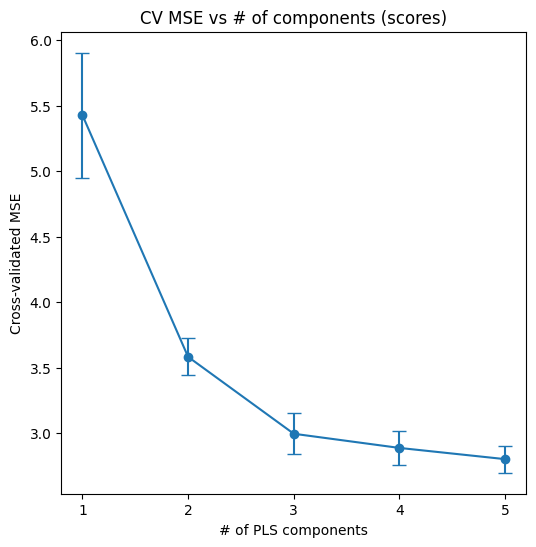

[BEM] Not fitting final score model yet. Call choose_n_components(k) after inspecting the CV plot.


In [378]:
df = pd.read_excel("synthesized_data.xlsx")
X_cols = ['acetate_mM', 'glucose_g_L', 'magnesium_mM', 'nh3_mM', 'phosphate_mM']

bem = BatchEvolutionModel(
    X_cols=X_cols,
    batch_col='batch_id',
    time_col='batch_time_h',
    y_time_col='batch_time_h',
)

bem.fit_scores(df, n_splits=5, max_components=None, plot_cv=True, auto_select=False)

In [379]:
df 

,batch_id,batch_time_h,titer_mg_mL,acetate_mM,glucose_g_L,magnesium_mM,nh3_mM,phosphate_mM
0,S1_syn_001,0,0.016667,44.156491,0.023141,11.821203,17.695473,12.888215
1,S1_syn_001,1,0.075776,52.151055,0.024878,11.855727,20.606514,14.132682
2,S1_syn_001,2,0.124705,59.551010,0.024873,11.908621,22.694492,15.016076
3,S1_syn_001,3,0.183994,63.674083,0.024147,11.761711,24.533753,15.429309
4,S1_syn_001,4,0.240574,67.732662,0.024206,11.837803,25.730974,16.153101
...,...,...,...,...,...,...,...,...
443,S2_syn_001,18,0.357560,110.483756,3.009253,9.096292,27.882335,11.146095
444,S2_syn_001,19,0.359514,120.938154,2.930723,8.930978,31.523793,11.201272
445,S2_syn_001,20,0.355689,134.034408,2.900010,8.712581,36.401076,10.784896
446,S2_syn_001,21,0.349232,151.186746,3.084588,8.671827,41.098266,10.124767


In [380]:
#manually select components from elbow plot
bem.choose_n_components(2)
bem.plot_scores(components=2)

[BEM] Fitting score model with n_components = 2
[BEM] plotting component 1


[BEM] plotting component 2


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('6AA6DrIY/r9SXn0NcVX8v98jFB/j1/' ... 'wDpbr6P3NKlDDVnfc/NQPhjs538T8='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0,

In [381]:
bem._df_model_scores


,batch_time_h,batch_id,acetate_mM,glucose_g_L,magnesium_mM,nh3_mM,phosphate_mM
0,0,S1_syn_001,44.156491,0.023141,11.821203,17.695473,12.888215
1,1,S1_syn_001,52.151055,0.024878,11.855727,20.606514,14.132682
2,2,S1_syn_001,59.551010,0.024873,11.908621,22.694492,15.016076
3,3,S1_syn_001,63.674083,0.024147,11.761711,24.533753,15.429309
4,4,S1_syn_001,67.732662,0.024206,11.837803,25.730974,16.153101
...,...,...,...,...,...,...,...
443,18,S2_syn_001,110.483756,3.009253,9.096292,27.882335,11.146095
444,19,S2_syn_001,120.938154,2.930723,8.930978,31.523793,11.201272
445,20,S2_syn_001,134.034408,2.900010,8.712581,36.401076,10.784896
446,21,S2_syn_001,151.186746,3.084588,8.671827,41.098266,10.124767


In [370]:
bem._X_scaled_scores #(NxJ)xA

array([[-1.81363395, -0.22873695,  0.75606537, -1.61051538, -0.53207988],
       [-1.3434452 , -0.22589183,  0.77142024, -1.43674947, -0.07817501],
       [-0.90822755, -0.22589994,  0.79494534, -1.31211387,  0.24403299],
       ...,
       [ 3.4724057 ,  4.48307924, -0.62653013, -0.4939403 , -1.29924104],
       [ 4.48119564,  4.78538722, -0.64465594, -0.21355554, -1.54001562],
       [ 5.63445967,  5.01471467, -0.62650087,  0.10723156, -1.50395689]],
      shape=(448, 5))

In [371]:
bem.pls_scores_df_train

,batch_time_h,batch_id,comp_1,comp_2,T2,DModX
0,0,S1_syn_001,-1.881029,-1.065305,3.481436,1.064016
1,1,S1_syn_001,-1.770860,-0.672818,2.268703,0.737480
2,2,S1_syn_001,-1.677707,-0.405744,1.679391,0.471199
3,3,S1_syn_001,-1.540323,-0.265011,1.314393,0.360513
4,4,S1_syn_001,-1.520519,-0.046729,1.182971,0.269680
...,...,...,...,...,...,...
443,18,S2_syn_001,0.395092,-0.593601,0.600008,2.850303
444,19,S2_syn_001,0.721470,-0.575384,0.754515,2.915925
445,20,S2_syn_001,1.187956,-0.652000,1.347899,3.069751
446,21,S2_syn_001,1.672568,-0.736354,2.228215,3.508583


In [372]:
bem.X_T_train

,comp_1_0,comp_1_1,comp_1_2,comp_1_3,comp_1_4,comp_1_5,comp_1_6,comp_1_7,comp_1_8,comp_1_9,...,comp_2_15,comp_2_16,comp_2_17,comp_2_18,comp_2_19,comp_2_20,comp_2_21,comp_2_22,comp_2_23,comp_2_24
batch_id,,,,,,,,,,,,,,,,,,,,,
S1_syn_001,-1.881029,-1.770860,-1.677707,-1.540323,-1.520519,-1.433933,-1.236389,-1.175117,-0.906803,-0.684905,...,-1.153356,-1.165854,-1.072330,-0.986628,-0.862414,-0.692851,-0.392029,-0.135452,0.399284,1.152459
S1_syn_002,-2.328009,-2.324964,-2.312744,-2.413968,-2.423931,-2.259301,-2.049563,-1.767754,-1.455579,-1.276704,...,-0.514580,-0.490180,-0.650483,-0.652769,-0.532636,-0.285412,-0.146653,0.176931,0.545428,1.294751
S1_syn_003,-1.804240,-1.885998,-1.870423,-1.805885,-1.773035,-1.723551,-1.344821,-1.161681,-1.011907,-0.867945,...,0.065711,0.012500,0.014769,0.132262,0.240069,0.498049,0.786831,1.291115,1.822093,2.688505
S1_syn_004,-1.522375,-1.460177,-1.417616,-1.492017,-1.457930,-1.238031,-1.102337,-0.780156,-0.759384,-0.430812,...,-0.804081,-0.852038,-0.936836,-0.826371,-0.672792,-0.478274,-0.150480,0.359764,0.810762,1.638149
S1_syn_005,-2.500780,-2.426615,-2.379729,-2.112921,-1.953154,-1.798046,-1.692517,-1.367998,-1.130553,-1.030297,...,-0.371110,-0.284790,-0.207792,-0.296023,-0.012963,0.324782,0.761540,1.161469,1.879463,2.504684
S1_syn_006,-2.223761,-2.103110,-2.026447,-1.893019,-1.805318,-1.587450,-1.385125,-1.214265,-0.970029,-0.734165,...,0.068129,0.093668,0.080839,0.158287,0.302136,0.665110,0.995376,1.404665,2.025231,2.693731
S1_syn_007,-1.542281,-1.826931,-1.610891,-1.453387,-1.352197,-1.434731,-1.176928,-1.162649,-0.865030,-0.569408,...,-1.247469,-1.252803,-1.201386,-1.167554,-1.022019,-1.062739,-0.473558,-0.185370,0.111990,0.632197
S1_syn_008,-2.000044,-1.986261,-1.884374,-1.809721,-1.862263,-1.368061,-1.370352,-1.156047,-0.671438,-0.570135,...,-0.034313,-0.094192,-0.084353,0.008899,-0.032273,0.287364,0.771842,1.003863,1.716873,2.355323
S1_syn_009,-1.548344,-1.590310,-1.560423,-1.610229,-1.423249,-1.136497,-1.129834,-1.070187,-0.831017,-0.545783,...,-1.435226,-1.505797,-1.419349,-1.393262,-1.381761,-1.111116,-1.035362,-0.720243,-0.197877,0.402200


In [373]:
bem.summary_df

,comp_1_0,comp_1_1,comp_1_2,comp_1_3,comp_1_4,comp_1_5,comp_1_6,comp_1_7,comp_1_8,comp_1_9,...,comp_2_15,comp_2_16,comp_2_17,comp_2_18,comp_2_19,comp_2_20,comp_2_21,comp_2_22,comp_2_23,comp_2_24
mean,-1.868008,-1.860269,-1.819214,-1.754170,-1.690776,-1.542333,-1.375506,-1.163716,-0.941209,-0.735016,...,-0.584884,-0.601498,-0.582592,-0.524848,-0.411129,-0.203197,0.117431,0.472328,1.063393,1.758933
std,0.366518,0.349204,0.383765,0.386671,0.423118,0.401062,0.377897,0.344471,0.313758,0.318127,...,0.466258,0.474129,0.460319,0.455584,0.476722,0.538739,0.606181,0.641321,0.671169,0.687076
upper_3sd,-0.768455,-0.812656,-0.667919,-0.594158,-0.421421,-0.339148,-0.241816,-0.130304,0.000064,0.219363,...,0.813891,0.820890,0.798365,0.841903,1.019036,1.413020,1.935973,2.396290,3.076900,3.820162
lower_3sd,-2.967562,-2.907882,-2.970508,-2.914182,-2.960130,-2.745518,-2.509196,-2.197128,-1.882481,-1.689396,...,-1.983660,-2.023886,-1.963550,-1.891599,-1.841294,-1.819413,-1.701112,-1.451634,-0.950115,-0.302297


In [382]:
#plot new batch
df_new = pd.read_excel("new_batch_incomplete.xlsx")
df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx")

bem.choose_n_components(2)
pls_scores_df_new, X_T_new = bem.transform_new(df_new)
bem.plot_scores(components=2, X_T_new=X_T_new)

[BEM] Fitting score model with n_components = 2
[BEM] plotting component 1


[BEM] plotting component 2


[Figure({
     'data': [{'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_001</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_001',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
                     22.0, 23.0, 24.0],
               'y': {'bdata': ('6AA6DrIY/r9SXn0NcVX8v98jFB/j1/' ... 'wDpbr6P3NKlDDVnfc/NQPhjs538T8='),
                     'dtype': 'f8'}},
              {'hovertemplate': 'time: %{x}<br>score: %{y}<extra>S1_syn_002</extra>',
               'line': {'width': 1},
               'mode': 'lines',
               'name': 'S1_syn_002',
               'showlegend': False,
               'type': 'scatter',
               'x': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
                     12.0, 13.0, 14.0,

In [375]:
# For a training batch:
bem.plot_T2_trace(bem.pls_scores_df_train, batch_id="S1_syn_005")
bem.plot_DModX_trace(bem.pls_scores_df_train, batch_id="S1_syn_005")

#df_new = pd.read_excel("new_batch_incomplete.xlsx")  #S1_syn_018
#df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx") S1_syn_019
#df_new = pd.read_excel("new_batch_good.xlsx")  #S1_syn_013
df_new = pd.read_excel("new_batch_complete_deviation.xlsx")  #S1_syn_020
#df_new = pd.read_excel("new_batch_wrong.xlsx")  #S2_syn_021
nbatch='S1_syn_020'
''
# New evolving batch:
pls_scores_df_new, X_T_new = bem.transform_new(df_new)
# For a new evolving batch:
bem.plot_T2_trace(pls_scores_df_new, batch_id=nbatch)
bem.plot_DModX_trace(pls_scores_df_new, batch_id=nbatch)

In [337]:
# 1. Quick look at numbers
contrib = bem.score_contributions_for_batch_time(
    df_raw=df_new,
    batch_id=nbatch,
    time_value=6.0,
    comp_index=0,          # comp_1
    use_abs=True,
)
print("Top contributors:\n", contrib.head(10))

# 2. Plot contribution bar chart
bem.plot_score_contributions_for_batch_time(
    df_raw=df_new,
    batch_id=nbatch,
    time_value=6.0,
    components=None,
    top_n=10,
    use_abs=True,
    title_prefix="Score contributions at deviation",
)


Top contributors:
 magnesium_mM    0.436213
nh3_mM         -0.406417
phosphate_mM    0.206776
acetate_mM     -0.154005
glucose_g_L     0.010873
dtype: float64


[Figure({
     'data': [{'hovertemplate': 'Variable: %{x}<br>Contribution: %{y}<extra></extra>',
               'name': 'comp_1',
               'type': 'bar',
               'x': [magnesium_mM, nh3_mM, phosphate_mM, acetate_mM, glucose_g_L],
               'y': {'bdata': '1Py87ejq2z+jL5DRugLav0V2L5ikd8o/Iy2z+2y2w7+aAjoKWUSGPw==', 'dtype': 'f8'}}],
     'layout': {'template': '...',
                'title': {'text': 'Score contributions at deviation – batch S1_syn_020, batch_time_h=6.0, comp_1'},
                'xaxis': {'tickangle': -45, 'title': {'text': 'Variable'}},
                'yaxis': {'title': {'text': 'Contribution (standardized units)'}}}
 }),
 Figure({
     'data': [{'hovertemplate': 'Variable: %{x}<br>Contribution: %{y}<extra></extra>',
               'name': 'comp_2',
               'type': 'bar',
               'x': [phosphate_mM, nh3_mM, glucose_g_L, acetate_mM, magnesium_mM],
               'y': {'bdata': 'UGrUHSx15D/4hlXRV+nSPwj3d05H38y/9dgEqstZxr+89nsC8DCaPw==', '

Adding Batch Level Data

[BEM] CV complete. Best # of response components (by MSE): 4


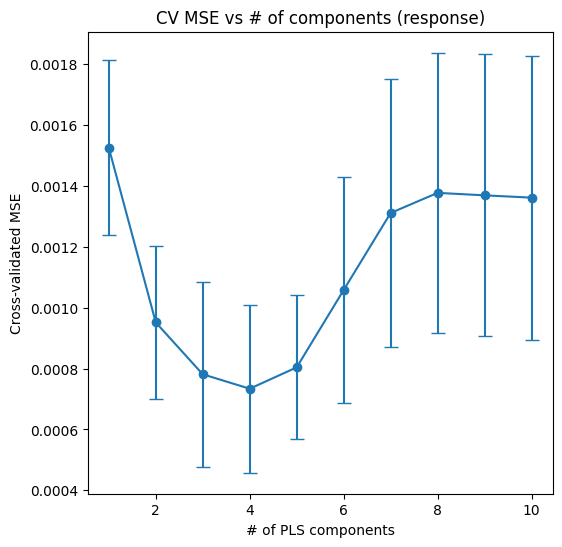

[BEM] Not fitting final response model yet. Call choose_n_response_components(k) after inspecting the CV plot.


In [ ]:
#merge scores df X_T_df with batch level info (1 per batch) to predict titer.
df_batch=pd.read_excel("batch_level_data.xlsx")

bem.fit_response_model(
    df_batch=df_batch,
    y_cols=['titer_mg_mL'],
    meta_cols=['batch_id', 'final_weight','temp_processing'],
    n_splits=5,
    plot_cv=True,
    auto_select=False,
)



In [341]:
# Look at the CV plot, then:
bem.choose_n_response_components(4)

#df_new = pd.read_excel("new_batch_incomplete.xlsx")  #S1_syn_018
#df_new = pd.read_excel("new_batch_incomplete_deviation.xlsx") S1_syn_019
df_new = pd.read_excel("new_batch_good.xlsx")  #S1_syn_013
#df_new = pd.read_excel("new_batch_wrong.xlsx")  #S2_syn_021

pls_scores_df_new, X_T_new = bem.transform_new(df_new)
preds_Z = bem.predict_response_for_new(X_T_new, df_batch_new=df_batch)
preds_Z


[BEM] Choosing response n_components = 4
[BEM] Fitted response model with n_components = 4
test
X_T_new_df
     batch_id  comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
0  S1_syn_013 -1.715392 -1.737262 -1.742054 -1.798353 -1.509776 -1.429074   

   comp_1_6  comp_1_7  comp_1_8  ...  comp_2_15  comp_2_16  comp_2_17  \
0 -1.404506 -1.088988 -0.889564  ...  -0.437912  -0.337896  -0.430187   

   comp_2_18  comp_2_19  comp_2_20  comp_2_21  comp_2_22  comp_2_23  comp_2_24  
0  -0.359524  -0.147419    0.10467   0.571066   0.916591   1.532996   2.104511  

[1 rows x 51 columns]
df_combined_new
     batch_id  comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
0  S1_syn_013 -1.715392 -1.737262 -1.742054 -1.798353 -1.509776 -1.429074   

   comp_1_6  comp_1_7  comp_1_8  ...  comp_2_19  comp_2_20  comp_2_21  \
0 -1.404506 -1.088988 -0.889564  ...  -0.147419    0.10467   0.571066   

   comp_2_22  comp_2_23  comp_2_24  dilution_effect  final_weight  \
0   0.916591   1.53

,titer_mg_mL
S1_syn_013,0.400518


### additional steps

Include 'deviation' batch. DONE

Finish the prediction portion for new batch.

Include DModX or Hotellings squared.

Include Time difference samples (interpolation?)

## Batch in Progress

In [ ]:

#load completed batches (good batches)
#generate df_model, and X
#select model n_componenents
#generate scores (T) through PLS_1
#convert to T_df
#Rearrange to X_T
#Calculate means and intervals.
#Plot

#load incomplete batch.
#generate df_model
#generate scores (T) through PLS_1.
#convert to T_df
#Rearrange to X_T
#Plot in conjunction to evaluate the BEM current.

